# 歪み補正・台形補正

まっすぐ撮影できずに台形になっているような状態はperspective歪みなどと呼ばれる

**射影変換** （projective transformation）によって台形補正を行う


:::{margin}
射影変換は **透視変換** （perspective transformation）や **ホモグラフィ変換** （homography transformation）とも呼ばれる。
:::

## 方法

例えば画像内に長方形になるべきものが写っている場合、4点を検出して、まっすぐな歪みのない長方形にアフィン変換してやればよい。

点はkeypoints検出や直線検出の結果をもとに推定する

- 局所対応点（keypoints）を検出して、4点にまとめる
    - 例えばコーナー検出（corner detection）によって「角っぽい点」を全部検知してから適切にフィルタリング・統合する
- 線が直交する点が角なので、線を検出して直交点を推測する
    - 例えばハフ変換。ただし、太い線だと並行に検出するとは限らない。候補の線を全部出してしまう。Cannyなどで細線化する方法があるが、細線化が失敗すると後の工程が全部失敗するリスクもある
    - 例えばLSD（Line Segment Detection）

### 画像の例


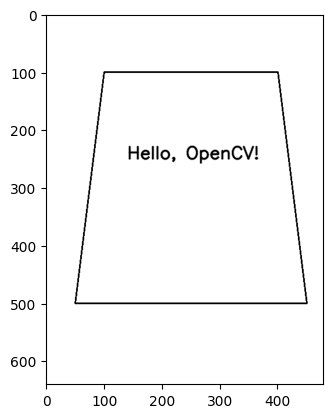

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 白い背景の画像を作成
width, height = 480, 640
img = np.ones((height, width, 3), dtype=np.uint8) * 255

# 台形の頂点を定義
pts = np.array([[100, 100], [400, 100], [450, 500], [50, 500]], np.int32)
pts = pts.reshape((-1, 1, 2))
# 台形を描画
cv2.polylines(img, [pts], isClosed=True, color=(0, 0, 0), thickness=2)

font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(img, 'Hello, OpenCV!', (140, 250), font, 1, (0, 0, 0), 2, cv2.LINE_AA)

# 円を描く
# cv2.circle(img, (250, 250), 100, (0, 0, 0), 1)

plt.imshow(img)
plt.show()

#### 前処理：台形の輪郭線を取り出す

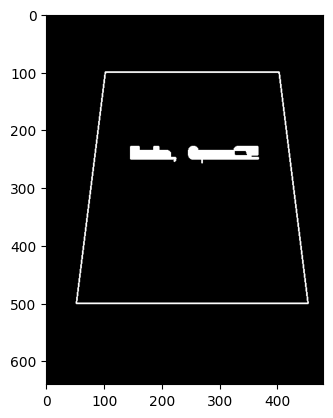

In [2]:
# 前処理：台形の輪郭線を取り出す

# グレースケール画像の取得
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 二値化
_, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY_INV)

# モルフォロジー変換：膨張と収縮を繰り返して線を抽出
kernel_length = max(1, img.shape[1] // 80)  # カーネルのサイズを画像の幅に基づいて決定
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 1))
morph = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)

plt.imshow(morph, cmap="gray")
plt.show()

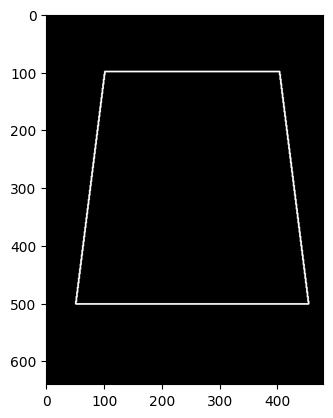

In [3]:
contours, _ = cv2.findContours(morph, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 輪郭を描画
contour_img = np.zeros_like(gray)
cv2.drawContours(contour_img, contours, -1, (255, 255, 255), 2)

plt.imshow(contour_img, cmap="gray")
plt.show()

#### 前処理：平滑化

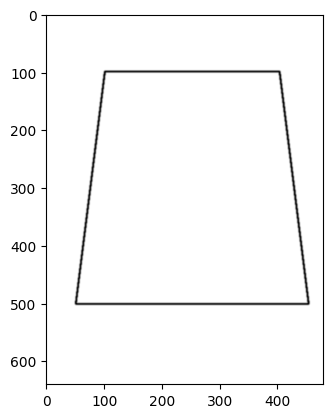

In [4]:
# 前処理2

# 白黒を反転
contour_img = 255 - contour_img

# 線がギザギザしているのでガウシアンブラーで平滑化
contour_img = cv2.GaussianBlur(contour_img, (5, 5), 0)

plt.imshow(contour_img, cmap="gray")
plt.show()

## 局所対応点を検出する方法

### Harrisによるコーナー検出

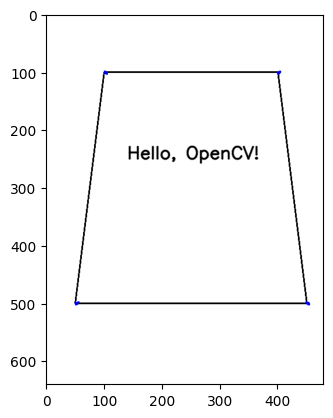

In [5]:
# Harris corner detection
dst = cv2.cornerHarris(np.float32(contour_img), blockSize=2, ksize=3, k=0.04)
# Dilate the result to mark the corners
dst = cv2.dilate(dst, None)
# Threshold for an optimal value, marking the corners in the original image
img_harris = img.copy()
img_harris[dst > 0.01 * dst.max()] = [0, 0, 255]

plt.imshow(img_harris)

### FASTによるコーナー検出

FASTは16x16ピクセルの範囲ごとにグレースケール画像の濃淡の領域を分割するように決定木を構築してコーナーを検出する手法

[OpenCV: FAST Algorithm for Corner Detection](https://docs.opencv.org/3.4/df/d0c/tutorial_py_fast.html)

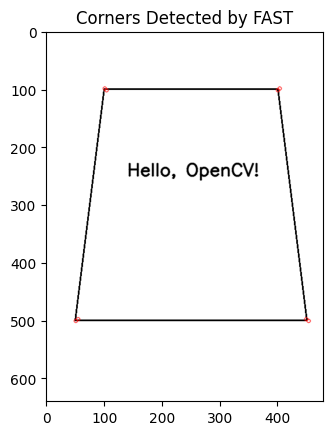

In [6]:
fast = cv2.FastFeatureDetector_create(threshold=100)
keypoints = fast.detect(contour_img, None)

# 検出されたコーナーを画像に描画
image_with_keypoints = cv2.drawKeypoints(img, keypoints, None, color=(255, 0, 0))

plt.imshow(image_with_keypoints)
plt.title("Corners Detected by FAST")
plt.show()

### 検出したコーナーたちを4点にまとめる

In [7]:
# コーナーの座標を取得
corners = cv2.KeyPoint_convert(keypoints)
corners

array([[101.,  99.],
       [403.,  99.],
       [104., 102.],
       [400., 102.],
       [ 55., 498.],
       [449., 498.],
       [ 51., 501.],
       [453., 501.]], dtype=float32)

In [8]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(corners)
centroids = kmeans.cluster_centers_
centroids

array([[401.5, 100.5],
       [451. , 499.5],
       [ 53. , 499.5],
       [102.5, 100.5]], dtype=float32)

In [9]:
values = centroids[:, 0] + centroids[:, 1]
idx = np.argsort(values)
centroids = centroids[idx]
centroids

array([[102.5, 100.5],
       [401.5, 100.5],
       [ 53. , 499.5],
       [451. , 499.5]], dtype=float32)

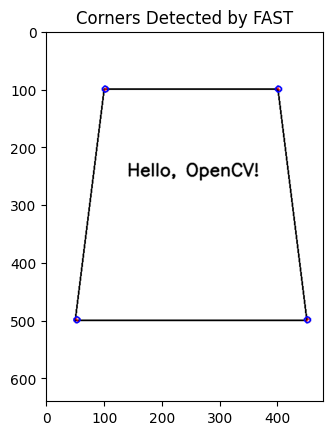

In [10]:
img_centroids = image_with_keypoints.copy()
for centroid in centroids:
    cv2.circle(img_centroids, tuple(centroid.astype("uint32")), radius=5, color=(0, 0, 255), thickness=2)

plt.imshow(img_centroids)
plt.title("Corners Detected by FAST")
plt.show()

## Perspective Transform

In [11]:
pts_src = centroids

In [12]:
# 変換後の座標（出力画像のサイズを決定）
# width, height = 300, 400  # 出力画像の幅と高さを指定
margin = 50  # 余白
pts_dst = np.array([
    [margin, margin],
    [width - margin - 1, margin],
    [margin, height - margin - 1],
    [width - margin - 1, height - margin - 1]
], dtype='float32')
pts_dst

array([[ 50.,  50.],
       [429.,  50.],
       [ 50., 589.],
       [429., 589.]], dtype=float32)

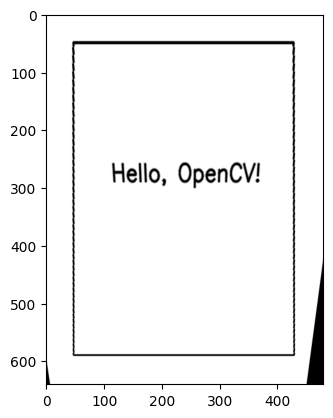

In [13]:
# 変換行列を計算
matrix = cv2.getPerspectiveTransform(pts_src, pts_dst)
# 変換を適用
transformed_img = cv2.warpPerspective(img, matrix, (width, height))

plt.imshow(transformed_img, cmap="gray")

## 直線を検出する場合

LSDはライセンスの問題でOpenCVからは削除されたようで、使いたい場合は [pylsd](https://github.com/primetang/pylsd) をインストールする必要がある。

代わりに [FastLineDetector](https://docs.opencv.org/4.x/df/d4c/classcv_1_1ximgproc_1_1FastLineDetector.html) というものがある。（Python使用例：[Python+OpenCVによる線分検出 - 社会人研究者が色々頑張るブログ](https://nsr-9.hatenablog.jp/entry/2021/08/12/200000)）

:::{margin}
`FastLineDetector` は cv2.ximgprocパッケージに入っており、opencvとは別に

```sh
pip install opencv-contrib-python
```

でインストールする必要がある。
:::

#### 直線を検出する

ぴったり4つではなく8つくらい出てる

8 lines are detected


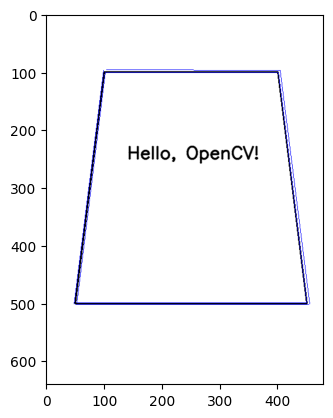

In [97]:
length_threshold = 10
distance_threshold = 1.41421356
canny_th1 = 50
canny_th2 = 50
canny_aperture_size = 3
do_merge = False

fld = cv2.ximgproc.createFastLineDetector(
    length_threshold,
    distance_threshold,
    canny_th1,
    canny_th2,
    canny_aperture_size,
    do_merge
)

lines_raw = fld.detect(contour_img)
# 形状を整える
lines = [line[0] for line in lines_raw]

# drawSegmentsで描く場合
# img_lines = fld.drawSegments(img, lines)
# plt.imshow(img_lines)

# cv2.lineで描く場合
print(f"{len(lines)} lines are detected")
out = img.copy()
for line in lines:
    x1, y1, x2, y2 = map(int, line)
    cv2.line(out, (x1, y1), (x2, y2), (0, 0, 255), 1)
plt.imshow(out)

### 交点を出すために直線を延長する

$$
\begin{align}
\text{diff}
&= P_1 - P_2
\\
&= \begin{pmatrix} x_1 \\ y_1 \end{pmatrix}
-
\begin{pmatrix} x_2 \\ y_2 \end{pmatrix}
\\
\text{direction} &= \frac{\text{diff}}{ \|\text{diff}\| }\\
P_1^{new} &= \begin{pmatrix} x_1 \\ y_1 \end{pmatrix} - \text{direction} \times \text{length}\\
P_2^{new} &= \begin{pmatrix} x_2 \\ y_2 \end{pmatrix} + \text{direction} \times \text{length}\\
\end{align}
$$

In [167]:
def extend_line(p1, p2, length):
    diff = np.array(p2) - np.array(p1)
    direction = diff / np.linalg.norm(diff)
    new_p1 = np.array(p1) - direction * length
    new_p2 = np.array(p2) + direction * length
    new_p1 = tuple(map(int, new_p1))
    new_p2 = tuple(map(int, new_p2))
    return new_p1, new_p2

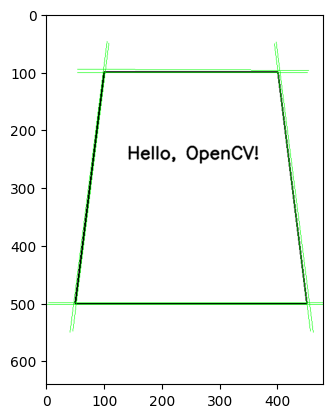

In [168]:
out = img.copy()
for line in lines:
    x1, y1, x2, y2 = map(int, line)
    p1_, p2_ = extend_line(p1=(x1, y1), p2=(x2, y2), length=50)
    cv2.line(out, p1_, p2_, (0, 255, 0), 1)
    # break
plt.imshow(out)

### 2つの線の交点を出す

4つの点

$$
P_1 = (x_1, y_1), \quad
P_2 = (x_2, y_2), \quad
P_3 = (x_3, y_3), \quad
P_4 = (x_4, y_4)
$$

からなる2つの線分

$$
L_1(t) = (1 - t) P_1 + t P_2, \quad (0\leq t \leq 1)
L_2(u) = (1 - u) P_3 + u P_4, \quad (0\leq u \leq 1)
$$

を用いて、交点$(x,y)$を求める連立方程式を組む

$$
\left\{\begin{array}{l}
x=(1-t) x_1+t x_2 \\
x=(1-u) x_3+u x_4 \\
y=(1-t) y_1+t y_2 \\
y=(1-u) y_3+u y_4
\end{array}\right.
$$

整理すると

$$
\left\{\begin{array}{l}
\left(x_2-x_1\right) t-\left(x_4-x_3\right) u=x_3-x_1 \\
\left(y_2-y_1\right) t-\left(y_4-y_3\right) u=y_3-y_1
\end{array}\right.
$$

となる。行列表記にすると以下のようになる。

$$
\left(\begin{array}{ll}
x_2-x_1 & -\left(x_4-x_3\right) \\
y_2-y_1 & -\left(y_4-y_3\right)
\end{array}\right)\binom{t}{u}=\binom{x_3-x_1}{y_3-y_1}
$$

行列式

$$
\operatorname{det}
=\left|\begin{array}{ll}
x_2-x_1 & -\left(x_4-x_3\right) \\
y_2-y_1 & -\left(y_4-y_3\right)
\end{array}\right|
=\left(x_2-x_1\right)\left(y_4-y_3\right)-\left(y_2-y_1\right)\left(x_4-x_3\right)
$$

がゼロでなければ、クラメルの公式により

$$
\begin{aligned}
& t=\frac{\left(x_3-x_1\right)\left(y_4-y_3\right)-\left(y_3-y_1\right)\left(x_4-x_3\right)}{\operatorname{det}} \\
& u=\frac{\left(x_2-x_1\right)\left(y_3-y_1\right)-\left(y_2-y_1\right)\left(x_3-x_1\right)}{\operatorname{det}}
\end{aligned}
$$

として解が求まる

In [169]:
def get_line_intersection(line1, line2):
    x1, y1, x2, y2 = line1
    x3, y3, x4, y4 = line2
    # Calculate the determinant
    det = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    if det == 0:
        return None  # Lines are parallel or coincident
    # Calculate the intersection point
    px = ((x1*y2 - y1*x2) * (x3 - x4) - (x1 - x2) * (x3*y4 - y3*x4)) / det
    py = ((x1*y2 - y1*x2) * (y3 - y4) - (y1 - y2) * (x3*y4 - y3*x4)) / det
    return int(px), int(py)

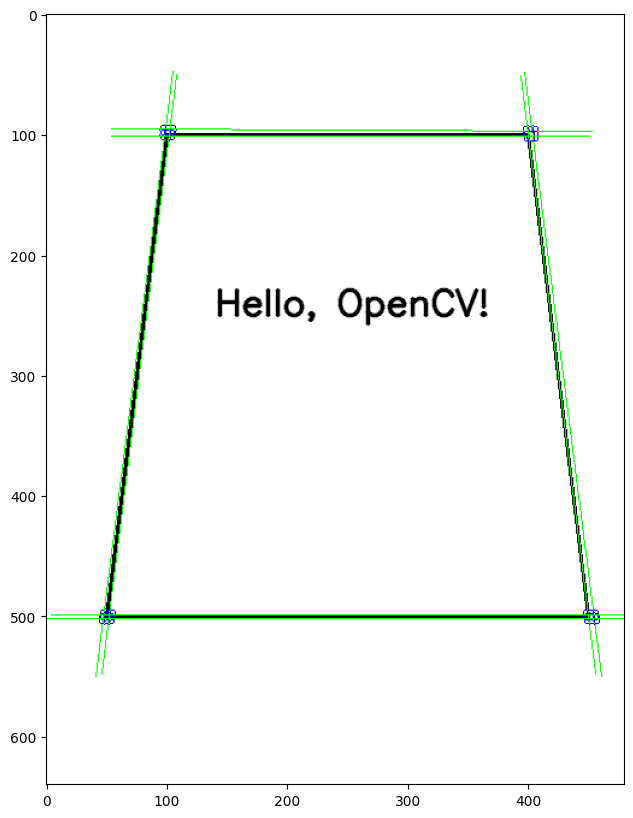

In [170]:
out = img.copy()
intersects = []
for i in range(len(lines)):
    for j in range(i, len(lines)):
        x1, y1, x2, y2 = map(int, lines[i])
        p1_, p2_ = extend_line(p1=(x1, y1), p2=(x2, y2), length=50)
        cv2.line(out, p1_, p2_, (0, 255, 0), 1)

        intersect = get_line_intersection(lines[i], lines[j])
        if intersect:
            x_, y_ = intersect
            if abs(x_) > out.shape[1] or abs(y_) > out.shape[0]:
                # 異常値は無視
                continue
            cv2.circle(out, intersect, radius=5, color=(0, 0, 255), thickness=1)
            intersects.append(intersect)
plt.figure(figsize=(10,10))
plt.imshow(out)

### 交点の中心点をとる


In [171]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(intersects)
centroids = kmeans.cluster_centers_
centroids

array([[402.25,  99.  ],
       [ 50.5 , 500.5 ],
       [452.5 , 500.5 ],
       [100.75,  98.  ]])

In [172]:
values = centroids[:, 0] + centroids[:, 1]
idx = np.argsort(values)
centroids = centroids[idx]
centroids

array([[100.75,  98.  ],
       [402.25,  99.  ],
       [ 50.5 , 500.5 ],
       [452.5 , 500.5 ]])

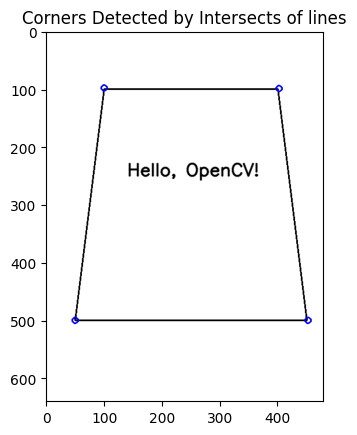

In [177]:
out = img.copy()
for centroid in centroids:
    cv2.circle(out, tuple(centroid.astype("uint32")), radius=5, color=(0, 0, 255), thickness=2)

plt.imshow(out)
plt.title("Corners Detected by Intersects of lines")
plt.show()

## Perspective Transform

In [182]:
pts_src = centroids.astype("float32")

In [193]:
# 変換後の座標（出力画像のサイズを決定）
# width, height = 300, 400  # 出力画像の幅と高さを指定
margin = 50  # 余白
pts_dst = np.array([
    [margin, margin],
    [width - margin - 1, margin],
    [margin, height - margin - 1],
    [width - margin - 1, height - margin - 1]
], dtype='float32')
pts_dst

array([[ 50.,  50.],
       [429.,  50.],
       [ 50., 589.],
       [429., 589.]], dtype=float32)

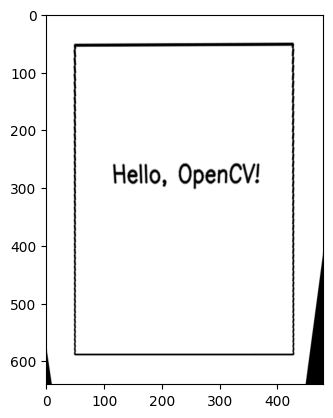

In [194]:
# 変換行列を計算
matrix = cv2.getPerspectiveTransform(pts_src, pts_dst)
# 変換を適用
transformed_img = cv2.warpPerspective(img, matrix, (width, height))

plt.imshow(transformed_img, cmap="gray")

## 参考

- [射影変換により画像から距離を推定する #Python - Qiita](https://qiita.com/ydclab_0003/items/1fc3d1468a39623bae60)
- [Skews and Perspectives with OpenCV - FreedomVC](https://www.freedomvc.com/index.php/2021/05/23/skews-and-perspectives/)
- [Python, OpenCVで幾何変換（アフィン変換・射影変換など） | note.nkmk.me](https://note.nkmk.me/python-opencv-warp-affine-perspective/)